# Regression model for metadata

In [1]:
import pandas as pd
import numpy as np
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import matplotlib.pyplot as plt

### Loading the data

In [2]:
y_metrics = pd.read_csv("../../reports/tot_loss_lstm.csv", index_col=0)["normalized_rmse"]
Y = y_metrics
x_metrics = pd.read_csv("../../data/raw/meta_data.csv", index_col=1).iloc[:, 1:]

In [3]:
exog = [
    "fullTimeEmployees",
    "overallRisk", 
    "dividendYield", 
    "marketCap", 
    "shortRatio", 
    "heldPercentInsiders", 
    "heldPercentInstitutions", 
    "numberOfAnalystOpinions"
]
X = x_metrics[exog]

In [4]:
tickers = y_metrics.index
X = X.loc[tickers, :]
X = add_constant(X)

### Some cleaning

In [5]:
too_high_error_tickers = Y[Y >= 10].index
X = X.drop(too_high_error_tickers)
Y = Y.drop(too_high_error_tickers)

X.loc[:, "dividendYield"] = X["dividendYield"].replace(np.nan, 0)
X.loc[:, "numberOfAnalystOpinions"] = X["numberOfAnalystOpinions"].replace(np.nan, 0)
X.loc[:, "overallRisk"] = X["overallRisk"].replace(np.nan, X["overallRisk"].mean())

In [6]:
tickers_to_drop = X.isna().sum(axis=1).astype(bool)
X = X[~tickers_to_drop]
Y = Y[~tickers_to_drop]

In [7]:
# Ensure you have no nan-values
X.isna().sum()

const                      0
fullTimeEmployees          0
overallRisk                0
dividendYield              0
marketCap                  0
shortRatio                 0
heldPercentInsiders        0
heldPercentInstitutions    0
numberOfAnalystOpinions    0
dtype: int64

### Save the data

In [8]:
X.to_csv("../../data/processed/X_regression.csv")
Y.to_csv("../../data/processed/Y_regression.csv")

### OLS

In [9]:
model = OLS(Y, X)
result = model.fit(cov_type='HC3')
result.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 7
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        normalized_rmse   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                 -0.113
Method:                 Least Squares   F-statistic:                    0.1514
Date:                Sat, 30 Nov 2024   Prob (F-statistic):              0.993
Time:                        16:23:36   Log-Likelihood:                -3.9041
No. Observations:                  50   AIC:                             25.81
Df Residuals:                      41   BIC:                             43.02
Df Model:                           8                                         
Covariance Type:                  HC3                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       1.1435      0.160      7.142      0.000       0.830       1.457
fullTimeEmployees       -8.853e-08    1.5e-06     -0.059      0.953   -3.03e-06    2.85e-06
overallRisk                -0.0206      0.021     -1.003      0.316      -0.061       0.020
dividendYield              -1.6696      1.755     -0.951      0.341      -5.109       1.770
marketCap                1.491e-12   1.76e-12      0.845      0.398   -1.97e-12    4.95e-12
shortRatio                  0.0053      0.006      0.845      0.398      -0.007       0.018
heldPercentInsiders         0.1449      0.268      0.541      0.589      -0.380       0.670
heldPercentInstitutions     0.0437      0.092      0.474      0.636      -0.137       0.224
numberOfAnalystOpinions    -0.0081      0.009     -0.939      0.348      -0.025       0.009
==============================================================================
Omnibus:                      104.791   Durbin-Watson:                   2.173
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3466.248
Skew:                           6.164   Prob(JB):                         0.00
Kurtosis:                      41.882   Cond. No.                     1.29e+12
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 1.29e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

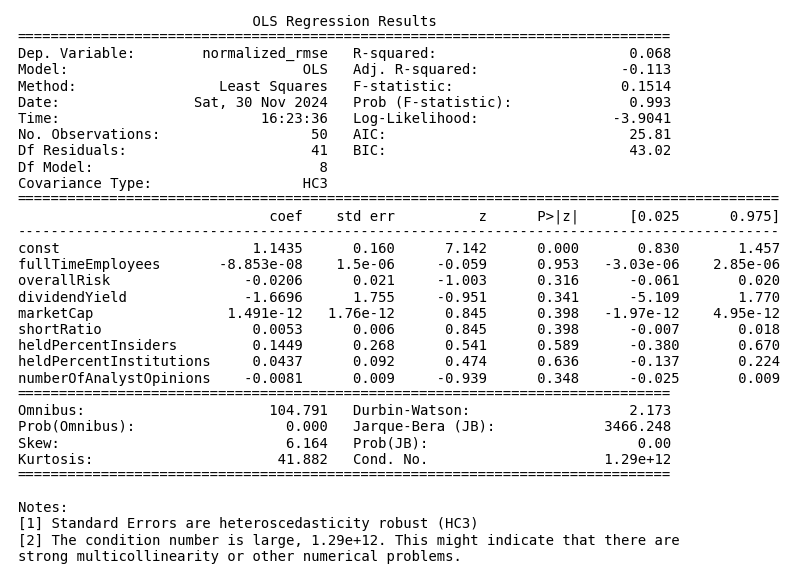

In [10]:
summary_text = result.summary().as_text()

# Render the summary as a PNG
plt.figure(figsize=(10, 6))
plt.text(0.01, 0.99, summary_text, fontsize=10, family='monospace', verticalalignment='top')
plt.axis('off')

# Save as PNG
plt.savefig("model_summary.png", dpi=300, bbox_inches='tight')
plt.show()

## Lasso

In [11]:
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Fit the Lasso regression model
lasso = Lasso(alpha=0.1)  # Adjust alpha for regularization strength
lasso.fit(X, Y)

# Predict on the test set
Y_pred = lasso.predict(X)

# Model evaluation
mse = mean_squared_error(Y, Y_pred)
r2 = r2_score(Y, Y_pred)

# Create a summary DataFrame for coefficients
coef_summary = pd.DataFrame({
    "Feature": X.columns,#[col for col in X.columns],  # Assuming feature names as X1, X2, etc.
    "Coefficient": lasso.coef_
})
coef_summary = coef_summary[coef_summary["Coefficient"] != 0]  # Optional: Filter non-zero coefficients

# Print summary
print("Lasso Regression Summary")
print("="*40)
print(f"Alpha (Regularization Strength): {lasso.alpha}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-Squared (R2): {r2:.4f}")
print("\nCoefficients:")
print(coef_summary.to_string(index=False))


Lasso Regression Summary
Alpha (Regularization Strength): 0.1
Mean Squared Error (MSE): 0.0727
R-Squared (R2): 0.0101

Coefficients:
          Feature   Coefficient
fullTimeEmployees -6.031866e-07
      overallRisk -1.884000e-03
        marketCap -4.705407e-13


In [ ]:
features = coef_summary.Feature

1    fullTimeEmployees
2          overallRisk
4            marketCap
Name: Feature, dtype: object


In [13]:
model = OLS(Y, add_constant(X[features]))
result = model.fit(cov_type='HC3')
result.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        normalized_rmse   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                 -0.034
Method:                 Least Squares   F-statistic:                    0.5308
Date:                Sat, 30 Nov 2024   Prob (F-statistic):              0.592
Time:                        16:23:37   Log-Likelihood:                -4.9245
No. Observations:                  50   AIC:                             17.85
Df Residuals:                      46   BIC:                             25.50
Df Model:                           3                                         
Covariance Type:                  HC3                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.1332      0.127      8.893      0.000       0.883       1.383
fullTimeEmployees -7.633e-07    1.7e-06     -0.449      0.654    -4.1e-06    2.57e-06
overallRisk          -0.0161      0.016     -1.015      0.310      -0.047       0.015
marketCap         -1.901e-13    8.6e-13     -0.221      0.825   -1.87e-12    1.49e-12
==============================================================================
Omnibus:                      108.883   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4057.312
Skew:                           6.538   Prob(JB):                         0.00
Kurtosis:                      45.149   Cond. No.                     5.17e+10
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 5.17e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""